In [1]:
from PIL import Image
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image, ImageDraw, ImageFont

In [2]:

model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
model.eval()


Using cache found in /home/jagadeesh/.cache/torch/hub/pytorch_vision_v0.10.0
/home/jagadeesh/Desktop/workspace/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jagadeesh/Desktop/workspace/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [9]:
def get_mask(filename):
    input_image = Image.open(filename)
    input_image = input_image.convert("RGB")
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model
    
    # move the input and model to GPU for speed if available
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')
    
    with torch.no_grad():
        output = model(input_batch)['out'][0]
    
    return input_image,output.argmax(0)


def get_TextAddededImage(image_path,mask,text,text_font,text_size,colour,position=None):
    indices = np.argwhere(mask.cpu() > 0)
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)
    try:
        font = ImageFont.truetype(text_font, size=text_size)  # Use an installed font
    except IOError:
        font = ImageFont.load_default()  # Load default font if specific font is not found
    bbox = draw.textbbox((0, 0), text, font=font)
    text_width = bbox[2] - bbox[0]  # Width of the text
    text_height = bbox[3] - bbox[1]
    x,y=int(indices[1][0]),int(indices[0][0])
    # position = (y-text_width//2,x-text_height//2)
    if position==None:
        position=(x-text_width//2,y-text_height//2)
    draw.text(position, text, fill=colour, font=font)
    return image.convert("RGB")  
    

def plot_Mask(mask,image):
    palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
    colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
    colors = (colors % 255).numpy().astype("uint8")

    # plot the semantic segmentation predictions of 21 classes in each color
    r = Image.fromarray(mask.byte().cpu().numpy()).resize(image.size)
    r.putpalette(colors)
    plt.imshow(r)

def out_put(mask,o_img,text_img):
    prediction_mask = mask.cpu()  # Random binary mask (0 or 1)
    o_img = np.array(o_img)  # Random image
    txt_img=np.array(text_img)
    prediction_mask_np = prediction_mask.numpy()
    binary_mask = (prediction_mask_np > 0).astype(np.uint8)
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros_like(o_img, dtype=np.uint8)
    cv2.drawContours(mask, contours, -1, (255, 255, 255), thickness=cv2.FILLED)
    cropped_image = cv2.bitwise_and(o_img, mask)
    background_mask = cv2.bitwise_not(mask)
    background_img=cv2.bitwise_and(txt_img,background_mask)
    final_image = cv2.add(background_img,cropped_image)
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].imshow(txt_img)
    axs[1].imshow(final_image)
    plt.show()

In [4]:
image_file="dog.jpg"
# image_file="content.png"
# image_file="deeplab1.png"

In [5]:
o_img,mask=get_mask(image_file)

In [22]:
text_img=get_TextAddededImage(
    image_path=image_file,
    mask=mask,text="WOOF..!",
    text_font='DejaVuSerif-BoldItalic.ttf',
    text_size=180,
    # position=(400,5),
    colour=(255,255,255))

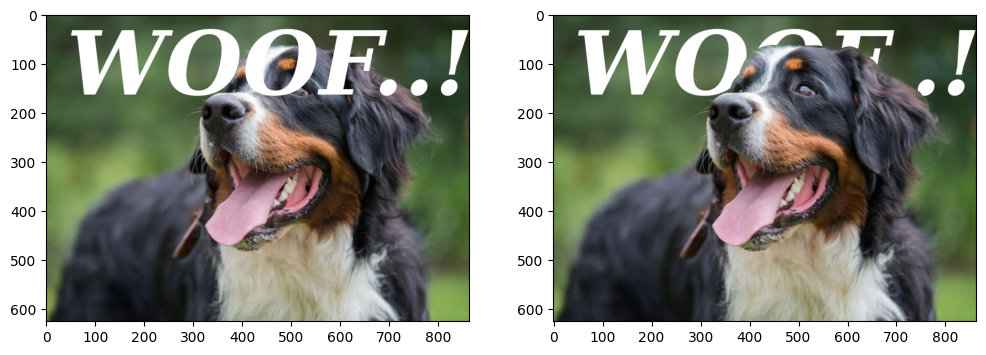

In [23]:
out_put(mask,o_img,text_img)

In [263]:
mask.shape,np.array(o_img).shape,np.array(text_img).shape

(torch.Size([411, 492]), (411, 492, 3), (411, 492, 3))

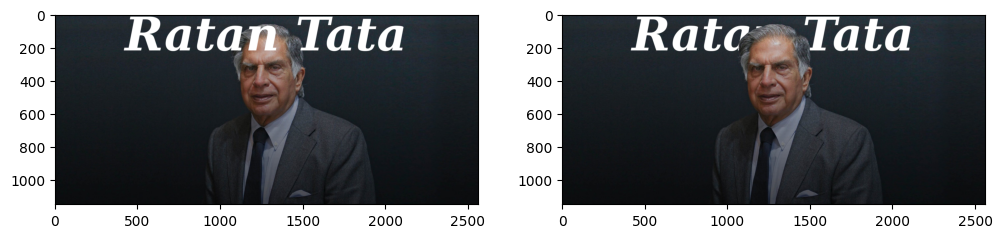

In [28]:
image_file="ratan-tata.jpg"
o_img,mask=get_mask(image_file)
text_img=get_TextAddededImage(
    image_path=image_file,
    mask=mask,text="Ratan Tata",
    text_font='DejaVuSerif-BoldItalic.ttf',
    text_size=280,
    # position=(400,5),
    colour=(255,255,255))
out_put(mask,o_img,text_img)